## Import libraries and init

In [1]:
# import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce
import pickle
import json
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import math
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

# import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

In [3]:
print(sys.version_info)
print(pd.__version__)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
0.24.2


## Load ntuples from analyzer

In [5]:
## new signal input
with open('config/sig.json') as sigs_json_file:
    sigs = json.load(sigs_json_file)

xrdfs = client.FileSystem("root://cmseos.fnal.gov/")

redirector = 'root://cmsxrootd.fnal.gov'
sig_base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/'
files = {}

for sig, properties in sigs.items():
    files[sig] = []
    status, listing = xrdfs.dirlist(f'{sig_base_dir}/{properties["dir"]}', DirListFlags.STAT)
    #print(listing)
    for file in listing:
        if '.root' in file.name:
            files[sig].append(f'{redirector}/{sig_base_dir}/{properties["dir"]}/{file.name}')
num_files_total = np.sum(np.array([len(files[i]) for i in files]))
print(num_files_total)
[(i, len(files[i])) for i in files]

16


[('Mchi-6p0_dMchi-2p0_ctau-1', 1),
 ('Mchi-6p0_dMchi-2p0_ctau-10', 1),
 ('Mchi-6p0_dMchi-2p0_ctau-100', 1),
 ('Mchi-6p0_dMchi-2p0_ctau-1000', 1),
 ('Mchi-60p0_dMchi-20p0_ctau-1', 1),
 ('Mchi-60p0_dMchi-20p0_ctau-10', 1),
 ('Mchi-60p0_dMchi-20p0_ctau-100', 1),
 ('Mchi-60p0_dMchi-20p0_ctau-1000', 1),
 ('Mchi-52p5_dMchi-5p0_ctau-1', 1),
 ('Mchi-52p5_dMchi-5p0_ctau-10', 1),
 ('Mchi-52p5_dMchi-5p0_ctau-100', 1),
 ('Mchi-52p5_dMchi-5p0_ctau-1000', 1),
 ('Mchi-5p25_dMchi-0p5_ctau-1', 1),
 ('Mchi-5p25_dMchi-0p5_ctau-10', 1),
 ('Mchi-5p25_dMchi-0p5_ctau-100', 1),
 ('Mchi-5p25_dMchi-0p5_ctau-1000', 1)]

In [10]:
%%time
genDfs = OrderedDict({})
genDfsload = OrderedDict({})
recoDfs = OrderedDict({})
recoDfsload = OrderedDict({})
dsaGenJet = OrderedDict({})
dsaGenJetload = OrderedDict({})
dsaGenMet = OrderedDict({})
dsaGenMetload = OrderedDict({})
dsaGenMu = OrderedDict({})
dsaGenMuload = OrderedDict({})
dsaGenChi2 = OrderedDict({})
dsaGenChi2load = OrderedDict({})
dsaGenAll = OrderedDict({})
MAX_FILES=None # To load all possible files

genNewDfs = OrderedDict({})
recoNewDfs = OrderedDict({})
leadingMuPt = OrderedDict({})
subleadingMuPt = OrderedDict({})

#MAX_FILES=4 # For testing
mchis = ['60p0', '52p5', '6p0', '5p25']
for Mchi in mchis:
    genDfs[Mchi] = OrderedDict({})
    genDfsload[Mchi] = OrderedDict({})
    recoDfs[Mchi] = OrderedDict({})
    recoDfsload[Mchi] = OrderedDict({})
    dsaGenJet[Mchi] = OrderedDict({})
    dsaGenJetload[Mchi] = OrderedDict({})
    dsaGenMet[Mchi] = OrderedDict({})
    dsaGenMetload[Mchi] = OrderedDict({})
    dsaGenMu[Mchi] = OrderedDict({})
    dsaGenMuload[Mchi] = OrderedDict({})
    dsaGenChi2[Mchi] = OrderedDict({})
    dsaGenChi2load[Mchi] = OrderedDict({})
    dsaGenAll[Mchi] = OrderedDict({})
    
    genNewDfs[Mchi] = OrderedDict({})
    recoNewDfs[Mchi] = OrderedDict({})
    leadingMuPt[Mchi] = OrderedDict({})
    subleadingMuPt[Mchi] = OrderedDict({})
    
    
global_file_counter = 1

for sig in sigs:
    
    print(f'Processing signal {sig} ({(list(sigs.keys())).index(sig)+1}/{len(sigs)})')
    
    Mchi = sig.split('_dMchi')[0].split('Mchi-')[1]
    ctau = sig.split('ctau-')[1]
   # print(sig,Mchi,ctau)
    genDfsload[Mchi][ctau] =[]
    recoDfsload[Mchi][ctau] =[]
    dsaGenJetload[Mchi][ctau] =[]
    dsaGenMetload[Mchi][ctau] =[]
    dsaGenMuload[Mchi][ctau] =[]
    dsaGenChi2load[Mchi][ctau] =[]

    ### Load data
    file_counter = 1
    for file in files[sig][slice(0,MAX_FILES)]:
        
        if file_counter % 10 == 1:
            print(f'Reading file {file_counter} of {len(files[sig])},'
                  f' global {global_file_counter} of {num_files_total}'
                  f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
        file_counter += 1
        global_file_counter += 1
        
        ### Open ROOT file and get tree
        genDfsload1 = uproot.open(file)['GEN/gen']
        genDfsload[Mchi][ctau].append(genDfsload1.pandas.df(['pid','pt','eta','phi','gen_vxy','gen_vz']))
        recoDfsload1 = uproot.open(file)['SREffi_dsa/reco']
        recoDfsload[Mchi][ctau].append(recoDfsload1.pandas.df(['trig_fired']))
        dsaGenload1 = uproot.open(file)['SREffi_dsa/gen']
        dsaGenJetload[Mchi][ctau].append(dsaGenload1.pandas.df(['gen_jet_pt','gen_jet_eta','gen_jet_phi']))#,'MET_pt','MET_phi','mu_pt','mu_eta','mu_phi'])).reset_level(level=1)
        dsaGenMetload[Mchi][ctau].append(dsaGenload1.pandas.df(['gen_MET_pt','gen_MET_phi']))#,'mu_pt','mu_eta','mu_phi'])).reset_level(level=1)
        dsaGenMuload[Mchi][ctau].append(dsaGenload1.pandas.df(['gen_mu_pt','gen_mu_eta','gen_mu_phi','gen_chi1_pt','gen_chi1_eta','gen_chi1_phi']))
        dsaGenChi2load[Mchi][ctau].append(dsaGenload1.pandas.df(['gen_chi2_pt','gen_chi2_eta','gen_chi2_phi']))
        #recoDfs[Mchi][ctau] = uproot.open(file)['SREffi_dsa/cutsTree']
        
        ### Make pandas dataframes and create all objects that will be passed to histo functions
        #obj_extractor = OE.ObjectExtractor(tree)
        #objects = obj_extractor.get_all()
    genDfs[Mchi][ctau]= pd.concat(genDfsload[Mchi][ctau])
    recoDfs[Mchi][ctau]= pd.concat(recoDfsload[Mchi][ctau])
    dsaGenJet[Mchi][ctau]= pd.concat(dsaGenJetload[Mchi][ctau]).groupby('entry').nth(0)
    #print(dsaGenJet[Mchi][ctau])
    dsaGenMet[Mchi][ctau]= pd.concat(dsaGenMetload[Mchi][ctau])
    dsaGenMu[Mchi][ctau]= pd.concat(dsaGenMuload[Mchi][ctau])
    dsaGenChi2[Mchi][ctau]= pd.concat(dsaGenChi2load[Mchi][ctau])
    dsaGenAll[Mchi][ctau] = dsaGenJet[Mchi][ctau].join(dsaGenMet[Mchi][ctau])

#print(recoDfs['60p0']['1'])

Processing signal Mchi-6p0_dMchi-2p0_ctau-1 (1/16)
Reading file 1 of 1, global 1 of 16 (0.00%)
Processing signal Mchi-6p0_dMchi-2p0_ctau-10 (2/16)
Reading file 1 of 1, global 2 of 16 (6.25%)
Processing signal Mchi-6p0_dMchi-2p0_ctau-100 (3/16)
Reading file 1 of 1, global 3 of 16 (12.50%)
Processing signal Mchi-6p0_dMchi-2p0_ctau-1000 (4/16)
Reading file 1 of 1, global 4 of 16 (18.75%)
Processing signal Mchi-60p0_dMchi-20p0_ctau-1 (5/16)
Reading file 1 of 1, global 5 of 16 (25.00%)
Processing signal Mchi-60p0_dMchi-20p0_ctau-10 (6/16)
Reading file 1 of 1, global 6 of 16 (31.25%)
Processing signal Mchi-60p0_dMchi-20p0_ctau-100 (7/16)
Reading file 1 of 1, global 7 of 16 (37.50%)
Processing signal Mchi-60p0_dMchi-20p0_ctau-1000 (8/16)
Reading file 1 of 1, global 8 of 16 (43.75%)
Processing signal Mchi-52p5_dMchi-5p0_ctau-1 (9/16)
Reading file 1 of 1, global 9 of 16 (50.00%)
Processing signal Mchi-52p5_dMchi-5p0_ctau-10 (10/16)
Reading file 1 of 1, global 10 of 16 (56.25%)
Processing signal

In [11]:
#genDfs['6p0']

## Muon pT plots

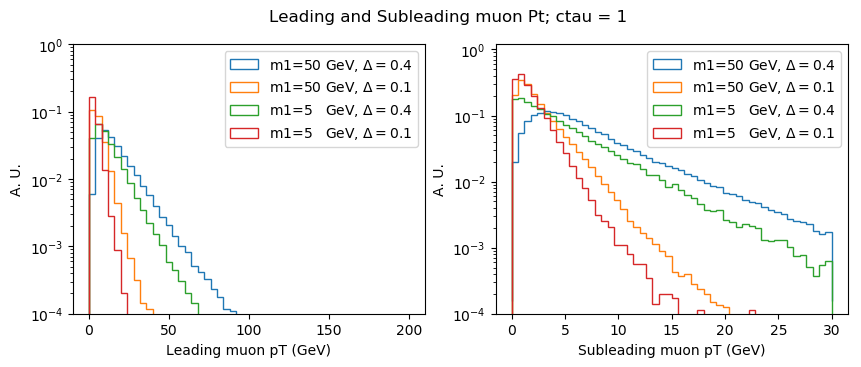

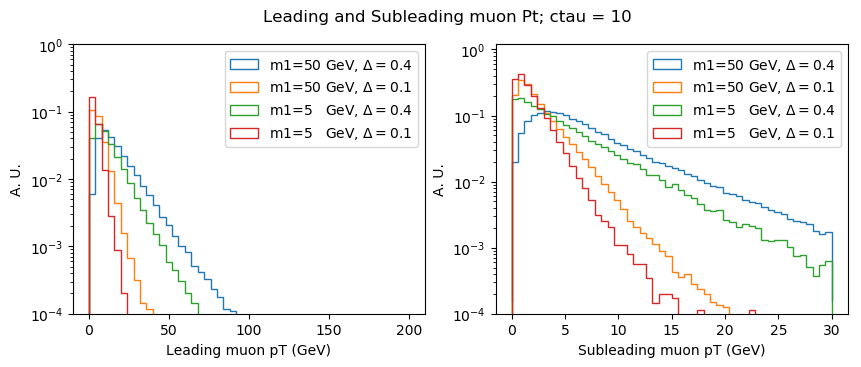

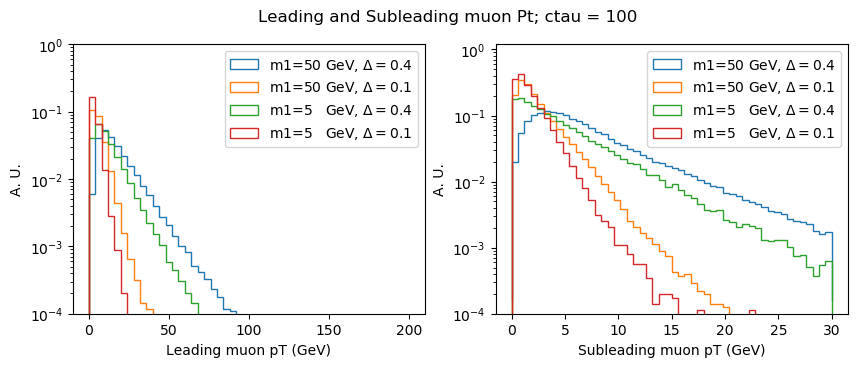

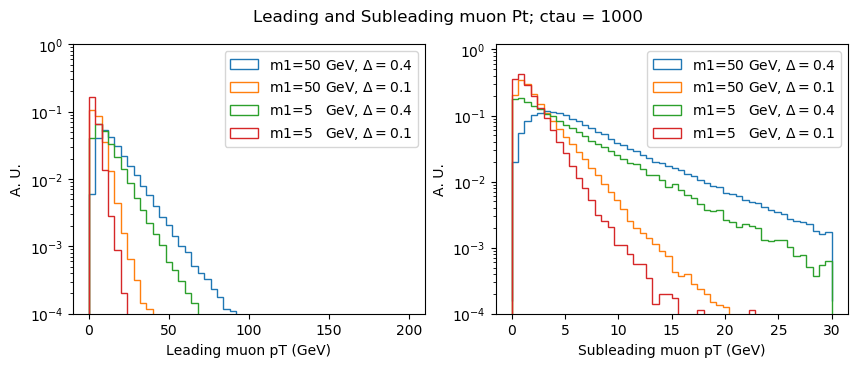

In [12]:
labels = {'60p0':'m1=50 GeV, $\Delta=0.4$', '52p5':'m1=50 GeV, $\Delta=0.1$', \
         '6p0':'m1=5   GeV, $\Delta=0.4$', '5p25':'m1=5   GeV, $\Delta=0.1$'}
mchis = ['60p0', '52p5', '6p0', '5p25']
ctaus = ['1', '10', '100', '1000']
#ctau = '1'
#fig, ax = plt.subplots(1,2, figsize=(10,3.5))


#genNewDfs = OrderedDict({})
#recoNewDfs = OrderedDict({})
#leadingMuPt = OrderedDict({})
#subleadingMuPt = OrderedDict({})
for ctau in ctaus:
    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    plt.suptitle("Leading and Subleading muon Pt; ctau = %s"%ctau)
#    genNewDfs[mchi] = OrderedDict({})
#    recoNewDfs[mchi] = OrderedDict({})
#    leadingMuPt[mchi] = OrderedDict({})
    for mchi in mchis:
        leadingMuPt[mchi][ctau] = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].max()
        #leadingMuPt[mchi][ctau] = genDfs[ctau][mchi].query('pid==13|pid==-13').groupby('entry')['pt'].max()
        ax[0].hist(leadingMuPt[mchi][ctau], bins=50, range=(0,200), histtype='step', density=True, log=True, label=labels[mchi]);
    ax[0].set_ylim([0.0001, 1])
    ax[0].set_xlabel('Leading muon pT (GeV)')
    ax[0].set_ylabel('A. U.')
    ax[0].legend();

#for mchi in mchis:
#    subleadingMuPt[mchi] = OrderedDict({})
    for mchi in mchis:
        subleadingMuPt[mchi][ctau] = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].min()
        #subleadingMuPt[mchi][ctau] = genDfs[ctau][mchi].query('pid==13|pid==-13').groupby('entry')['pt'].min()
        ax[1].hist(subleadingMuPt[mchi][ctau], bins=50, range=(0,30), histtype='step', density=True, log=True, label=labels[mchi]);
    ax[1].set_ylim([0.0001, 1.2])
    ax[1].set_xlabel('Subleading muon pT (GeV)')
    ax[1].set_ylabel('A. U.')
    ax[1].legend();
    plt.savefig("plots/GenKinematics/Gen_mu_pt_ctau_%s"%ctau, bbox_inches='tight')

## Muon phi and dR plots

In [13]:
# Helper function to normalize angle differences to [-Pi, Pi]
# cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
def reducephi(row):
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

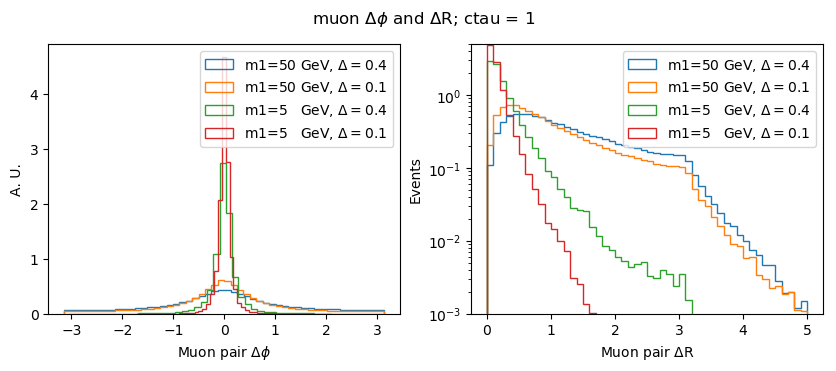

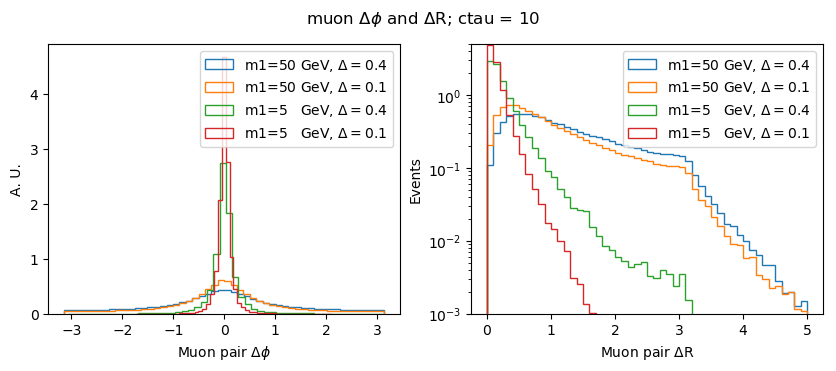

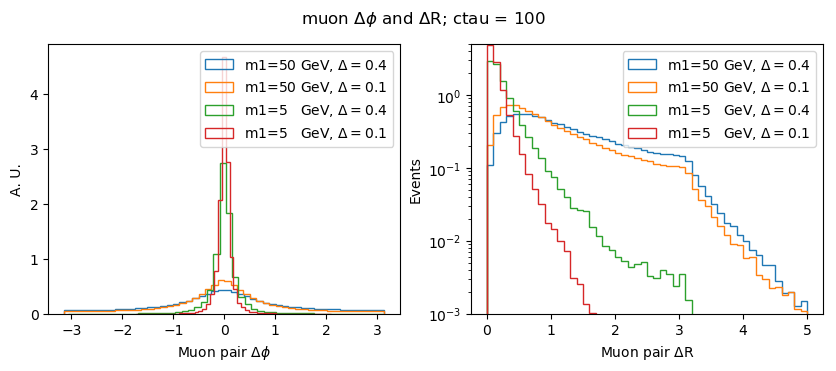

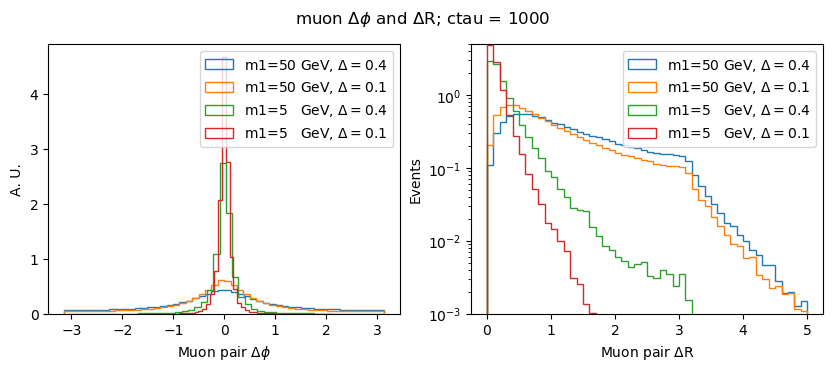

In [14]:
# plt.figure(figsize=(5,3.5))
#fig, ax = plt.subplots(1,2, figsize=(10,3.5))
for ctau in ctaus:
    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    plt.suptitle("muon $\Delta\phi$ and $\Delta$R; ctau = %s"%ctau)
    for mchi in mchis:
        reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)#[['eta','phi']]
        reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)#[['eta','phi']]
        phidiff = reducedGenDf_mu['phi'].sub(reducedGenDf_antimu['phi'])
        reducedphidiff = phidiff.apply(reducephi)
        ax[0].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);

    ax[0].set_xlabel('Muon pair $\Delta\phi$')
    ax[0].set_ylabel('A. U.')
    ax[0].legend();

    for mchi in mchis:
        reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)
        reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)
        phidiff = pd.concat([abs((math.pi - abs(reducedGenDf_mu['phi'])) + (math.pi - abs(reducedGenDf_antimu['phi']))), \
            abs(reducedGenDf_mu['phi'] - reducedGenDf_antimu['phi'])], axis=1).min(axis=1)
        deltaR = np.sqrt((reducedGenDf_mu['eta'] - reducedGenDf_antimu['eta'])**2 + (phidiff)**2)
        ax[1].hist(deltaR, bins=50, range=(0,5), density=True, log=True, histtype='step', label=labels[mchi]);

    ax[1].set_xlabel('Muon pair $\Delta$R')
    ax[1].set_ylabel('Events')
    ax[1].set_ylim(0.001, 5)
    ax[1].legend();
    plt.savefig("plots/GenKinematics/Gen_dPhi_dR_ctau= %s"%ctau, bbox_inches='tight')

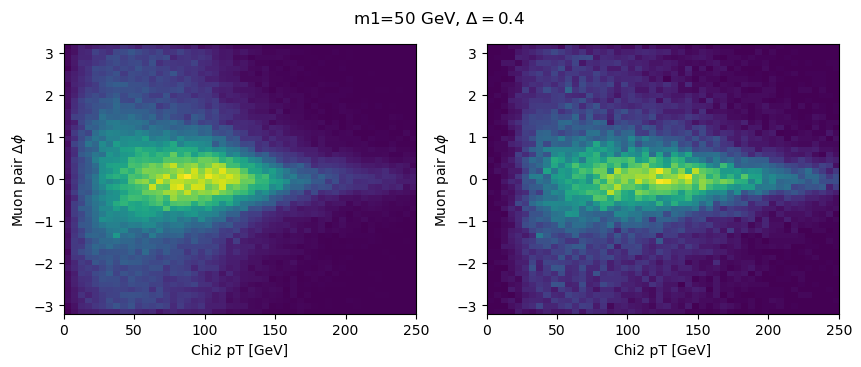

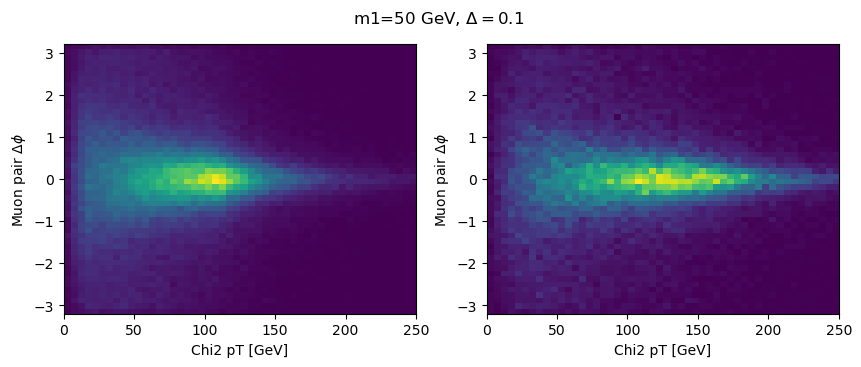

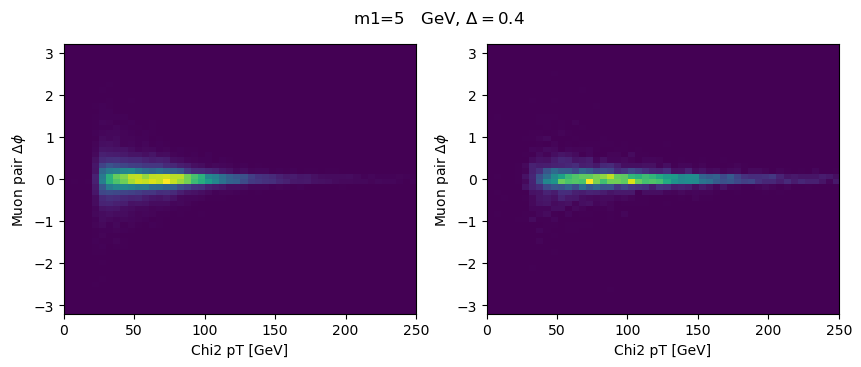

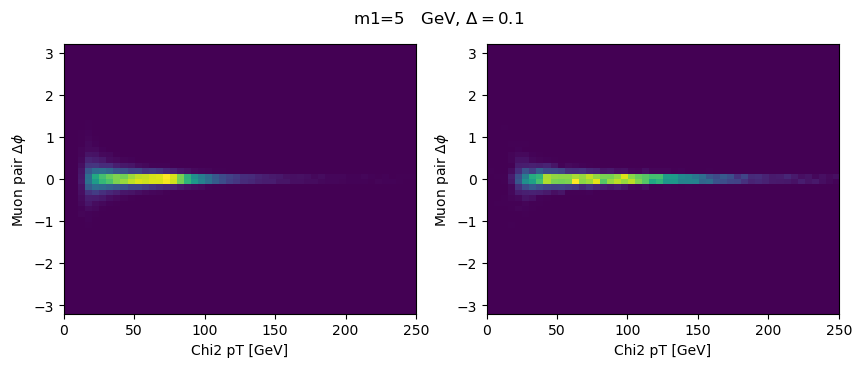

In [15]:
#mchi = '6p0'
ctau = '1'
for mchi in mchis:
    fig, axes = plt.subplots(1,2, figsize=(10,3.5))
    recoNewDfs[mchi][ctau] = recoDfs[mchi][ctau]['trig_fired']
    #print(recoNewDfs[mchi][ctau2])
    chi2pTs =  pd.DataFrame.from_dict(genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==1000023 ]['pt'])#.#reset_index(level=1)
    chi2pTs['trig_fired'] = recoDfs[mchi][ctau]['trig_fired'].tolist()
    #print(chi2pTs)

    reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)#[['eta','phi']]
    reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)#[['eta','phi']]
    phidiff = reducedGenDf_mu['phi'].sub(reducedGenDf_antimu['phi'])
    reducedphidiff = phidiff.apply(reducephi)
    #print(pd.DataFrame.from_dict(reducedphidiff))
    chi2pTs['phi'] = reducedphidiff.tolist()

    axes[0].hist2d(chi2pTs.dropna()['pt'], chi2pTs.dropna()['phi'], bins=(50,50), range=((0,250),(-3.2,3.2)));
    axes[0].set_xlabel('Chi2 pT [GeV]')
    axes[0].set_ylabel('Muon pair $\Delta\phi$');

    axes[1].hist2d(chi2pTs[chi2pTs['trig_fired']==1].dropna()['pt'], chi2pTs[chi2pTs['trig_fired']==1].dropna()['phi'], bins=(50,50), range=((0,250),(-3.2,3.2)));
    axes[1].set_xlabel('Chi2 pT [GeV]')
    axes[1].set_ylabel('Muon pair $\Delta\phi$');
    #fig.suptitle('5 GeV, Delta = 0.1');
    fig.suptitle(labels[mchi]);
    plt.savefig("plots/GenKinematics/Gen_Chi2Pt_Vs_dPhi_%s"%mchi, bbox_inches='tight')


#plt.hist(reducedphidiff,bins=50,histtype='step',density=True, label='All')
#plt.xlabel('Muon pair dPhi')
#plt.ylabel('A. U.')
#plt.hist(chi2pTs.dropna()['phi'],bins=50,histtype='step',density=True,label='Triggered');
#plt.legend();
#plt.title('5 GeV, Delta = 0.1');
#plt.savefig("plots/GenKinematics/Gen_Chi2Pt_Vs_dPhi", bbox_inches='tight')

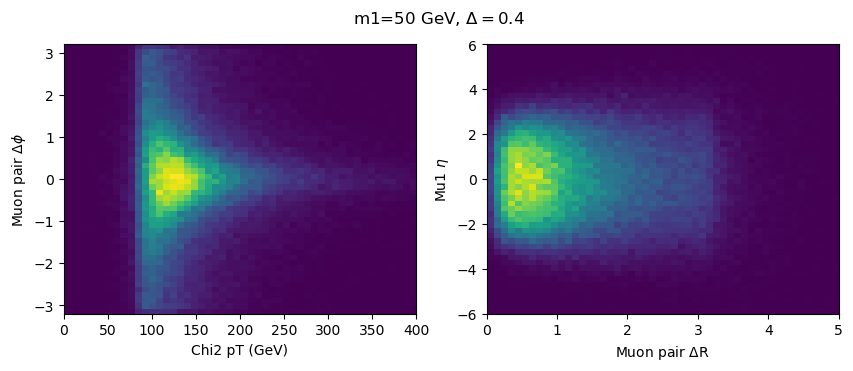

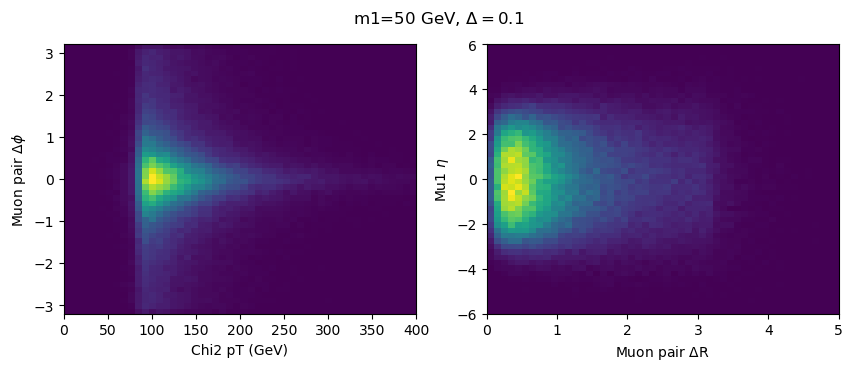

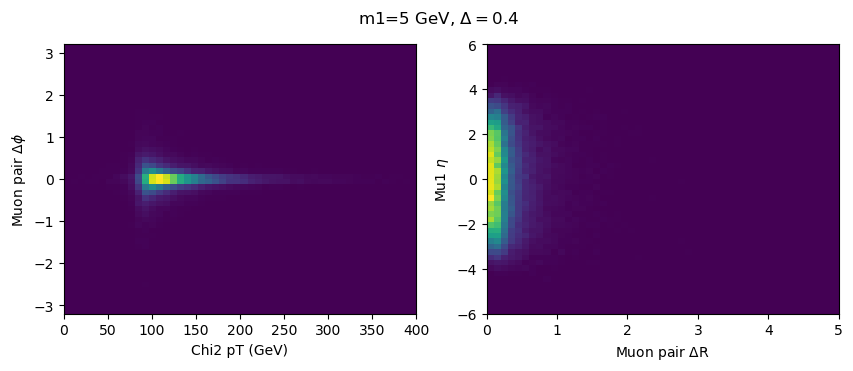

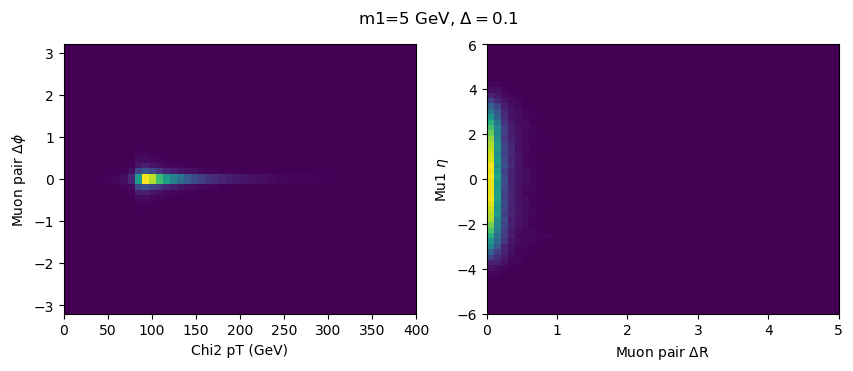

In [16]:
for mchi in mchis:
    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    fig.suptitle(' '.join(labels[mchi].split()))
    reducedGenDf_mu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==13].reset_index(level=1)
    reducedGenDf_antimu = genDfs[mchi][ctau][genDfs[mchi][ctau]['pid']==-13].reset_index(level=1)
    phidiff = reducedGenDf_mu['phi'].sub(reducedGenDf_antimu['phi'])
    reducedphidiff = phidiff.apply(reducephi)
    
    ax[0].hist2d(genDfs[mchi][ctau].loc[(slice(None), 2), :]['pt'], reducedphidiff, bins=(50,50), range=((0,400),(-3.2,3.2)));
    ax[0].set_ylabel('Muon pair $\Delta\phi$')
    ax[0].set_xlabel('Chi2 pT (GeV)')

    phidiff = pd.concat([abs((math.pi - abs(reducedGenDf_mu['phi'])) + (math.pi - abs(reducedGenDf_antimu['phi']))), \
        abs(reducedGenDf_mu['phi'] - reducedGenDf_antimu['phi'])], axis=1).min(axis=1)
    deltaR = np.sqrt((reducedGenDf_mu['eta'] - reducedGenDf_antimu['eta'])**2 + (phidiff)**2)
    
    ax[1].hist2d(deltaR, reducedGenDf_mu['eta'], label=labels[mchi], alpha=1.0, bins=(50,50), range=((0,5),(-6,6)))    
    ax[1].set_xlabel('Muon pair $\Delta$R')
    ax[1].set_ylabel('Mu1 $\eta$')
    plt.savefig("plots/GenKinematics/Gen_Chi2_vs_etaphi_%s"%mchi, bbox_inches='tight')

## Muon eta distributions

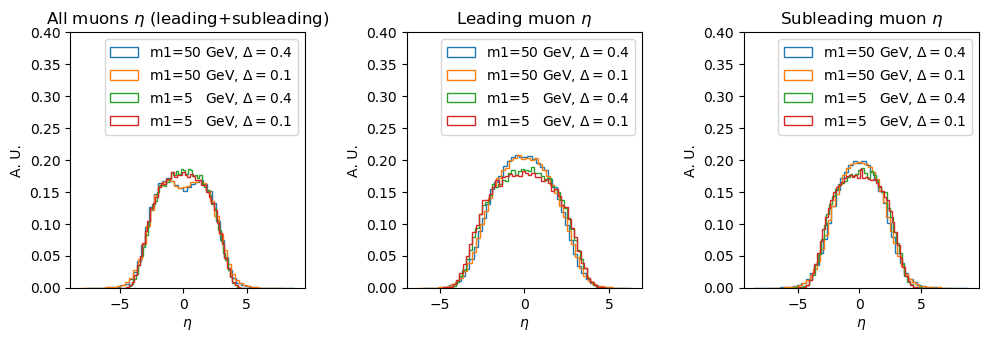

In [17]:
fig, ax = plt.subplots(1,3, figsize=(10,3.5))

for mchi in mchis:
    ax[0].hist(genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label=labels[mchi], histtype='step');

ax[0].set_xlabel('$\eta$')
ax[0].set_title('All muons $\eta$ (leading+subleading)')
ax[0].set_ylabel('A. U.')
ax[0].set_ylim(0, 0.4)
ax[0].legend();

for mchi in mchis:
    idx = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genDfs[mchi][ctau].query('pid==13|pid==-13')['pt']
    leadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[idx]
    subleadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[~idx]
    ax[1].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label=labels[mchi])
    ax[2].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label=labels[mchi])


ax[1].set_xlabel('$\eta$')
ax[1].set_title('Leading muon $\eta$')
ax[1].set_ylabel('A. U.')
ax[1].set_ylim(0, 0.4)
ax[1].legend();

ax[2].set_xlabel('$\eta$')
ax[2].set_title('Subleading muon $\eta$')
ax[2].set_ylabel('A. U.')
ax[2].set_ylim(0, 0.4)
ax[2].legend();

plt.tight_layout(pad=1.0)
plt.savefig("plots/GenKinematics/Gen_mu_eta", bbox_inches='tight')

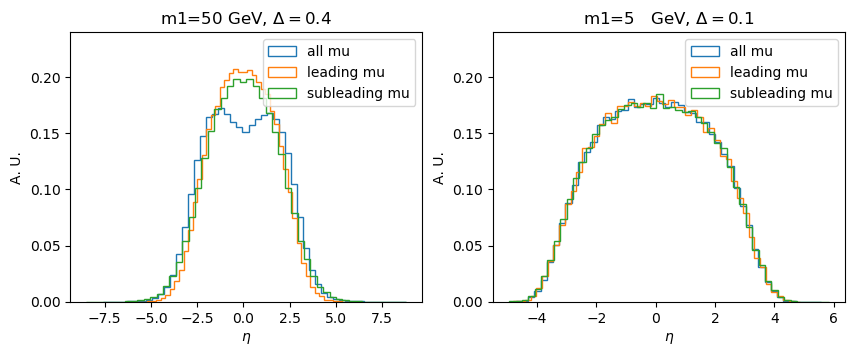

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

mchi = '60p0'
ctau='1'
ax[0].hist(genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label='all mu', histtype='step');
idx = genDfs[mchi][ctau].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genDfs[mchi][ctau].query('pid==13|pid==-13')['pt']
leadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[idx]
subleadingMu = genDfs[mchi][ctau].query('pid==13|pid==-13').loc[~idx]
ax[0].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label='leading mu');
ax[0].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label='subleading mu');

ax[0].set_xlabel('$\eta$')
ax[0].set_title(labels[mchi])
ax[0].set_ylabel('A. U.')
ax[0].set_ylim(0, 0.24)
ax[0].legend();

mchi = '5p25'
ctau2 = '1000'
ax[1].hist(genDfs[mchi][ctau2].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label='all mu', histtype='step');
idx = genDfs[mchi][ctau2].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genDfs[mchi][ctau2].query('pid==13|pid==-13')['pt']
leadingMu = genDfs[mchi][ctau2].query('pid==13|pid==-13').loc[idx]
subleadingMu = genDfs[mchi][ctau2].query('pid==13|pid==-13').loc[~idx]
ax[1].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label='leading mu');
ax[1].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label='subleading mu');

ax[1].set_xlabel('$\eta$')
ax[1].set_title(labels[mchi])
ax[1].set_ylabel('A. U.')
ax[1].set_ylim(0, 0.24)
ax[1].legend();
plt.savefig("plots/GenKinematics/Gen_mu_eta_stacked", bbox_inches='tight')

## Muons eta vs pT

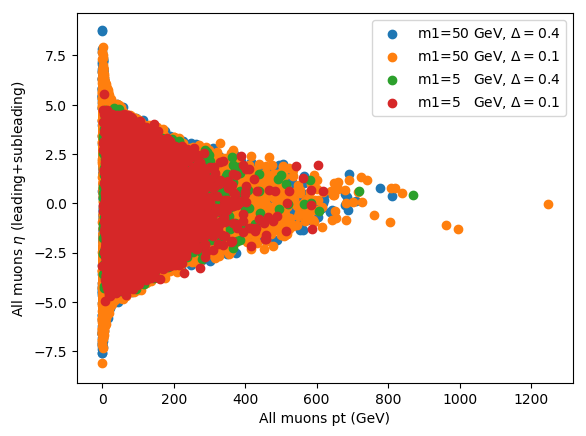

In [19]:
for mchi in mchis:
#     plt.hist(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label=labels[mchi], histtype='step');
    plt.scatter(genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['pt'], genDfs[mchi][ctau].loc[(slice(None), [5,6]), :]['eta'], label=labels[mchi])
    plt.ylabel('All muons $\eta$ (leading+subleading)')
    plt.xlabel('All muons pt (GeV)')
plt.legend();
plt.savefig("plots/GenKinematics/Gen_mupt_vs_mueta", bbox_inches='tight')

## Muon vxy and vz plots

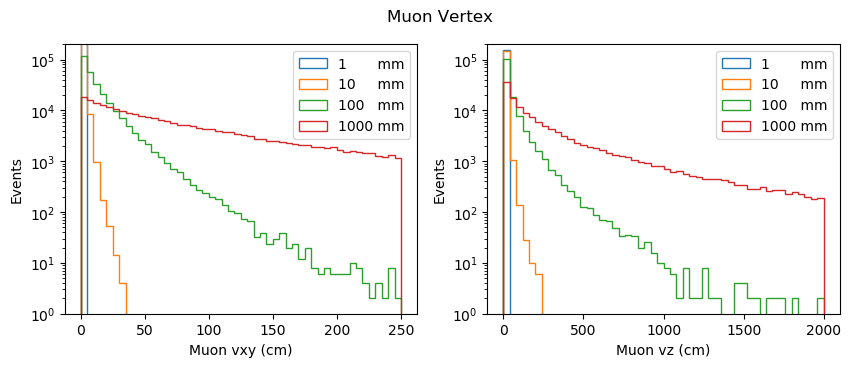

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
mchi='60p0'
ctaus = ['1','10','100','1000']
labels_ctau = {'1':'1       mm', '10':'10     mm', '100':'100   mm', '1000':'1000 mm'}
genDfs_v = OrderedDict({})
genDfs_v[mchi] = OrderedDict({})
for ctau in ctaus:
    genDfs_v[mchi][ctau] = genDfs[mchi][ctau]
    vxy = genDfs_v[mchi][ctau][(genDfs_v[mchi][ctau]['pid']==13) | (genDfs_v[mchi][ctau]['pid']==-13)]['gen_vxy']
    ax[0].hist(vxy, bins=50, range=(0,250), histtype='step', density=False, log=True, label=labels_ctau[ctau]);
ax[0].set_ylim([1, 200000])
ax[0].set_xlabel('Muon vxy (cm)')
ax[0].set_ylabel('Events')
ax[0].legend();

for ctau in ctaus:
    vz = genDfs_v[mchi][ctau][(genDfs_v[mchi][ctau]['pid']==13) | (genDfs_v[mchi][ctau]['pid']==-13)]['gen_vz']
    ax[1].hist(vz, bins=50, range=(0,2000), histtype='step', density=False, log=True, label=labels_ctau[ctau]);
ax[1].set_ylim([1, 200000])
ax[1].set_xlabel('Muon vz (cm)')
ax[1].set_ylabel('Events')
ax[1].legend();
plt.suptitle('Muon Vertex')
plt.savefig("plots/GenKinematics/Gen_mu_vxy_vz", bbox_inches='tight')

## Load files with additional data (jet eta and phi, MET phi) to make relevant plots

In [21]:
#masses = [('60','20'),('52p5','5p0'),('6p0','2p0'),('5p25','0p5')]
#mchis = ['60', '52p5', '6p0', '5p25']
#ctaus = [10]

#branchFolder = 'RECO_dsa'
#baseDir = '../Firefighter/washAOD/GenInfoStudies/'
#fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

#numParams = len(masses)*len(ctaus)
#count = 1

#recoNewDfs = OrderedDict({})
#genNewDfs = OrderedDict({})
#for (Mchi, dMchi) in masses:
#    recoNewDfs[Mchi] = OrderedDict({})
#    genNewDfs[Mchi] = OrderedDict({})
#    for ctau in ctaus:
#        recoNewDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['RECO_dsa' + '/recoEffiForMuTrack'].pandas.df()
#        genNewDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN' + '/gen'].pandas.df()
#        print(f'{count} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
#        count += 1

## Plot deltaPhi between jet and MET

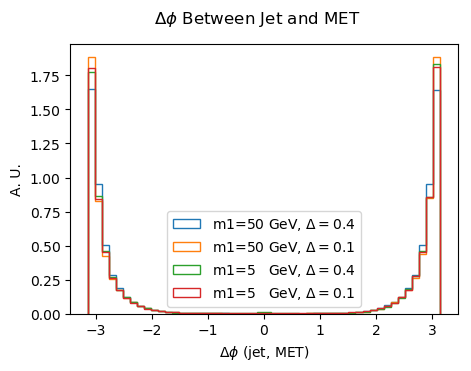

In [22]:
plt.figure(figsize=(5,3.5))
ctau='1'
for mchi in mchis:
    #reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    #reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    #phidiff = recoNewDfs[mchi][10]['genJetPhi'].dropna() - recoNewDfs[mchi][10]['genLeadMetPhi'].dropna()
    phidiff = dsaGenAll[mchi][ctau]['gen_jet_phi'].dropna() - dsaGenAll[mchi][ctau]['gen_MET_phi'].dropna()
    reducedphidiff = phidiff.apply(reducephi)
#     phidiff = pd.concat([abs((math.pi - abs(recoNewDfs[mchi][10]['genJetPhi'].dropna())) + (math.pi - abs(recoNewDfs[mchi][10]['genLeadMetPhi'].dropna()))), \
#         abs(recoNewDfs[mchi][10]['genJetPhi'].dropna() - recoNewDfs[mchi][10]['genLeadMetPhi'].dropna())], axis=1).min(axis=1)
    plt.hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi]);
plt.suptitle('$\Delta\phi$ Between Jet and MET')
plt.xlabel('$\Delta\phi$ (jet, MET)')
plt.ylabel('A. U.')
plt.legend(loc='lower center');
plt.savefig("plots/GenKinematics/Gen_Jet_Met_dPhi", bbox_inches='tight')

## Plot deltaPhi between MET and muon pair and between the 2 chi1 DM particles

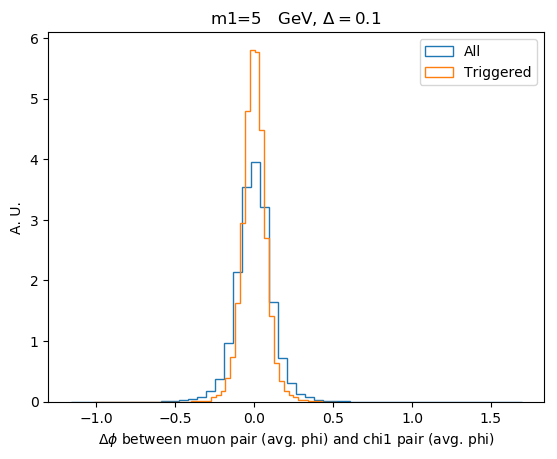

In [23]:
#mchi='6p0'
#ctau = '1'
#crit2Mus = dsaGenMu[mchi][ctau].query('subentry==1').reset_index()['entry']
#eventsWith2Mus = dsaGenMu[mchi][ctau].reset_index().loc[dsaGenMu[mchi][ctau].reset_index()['entry'].isin(crit2Mus) ]
#phi1 = eventsWith2Mus.query('subentry==0')['mu_phi'].reset_index()['mu_phi']
#phi2 = eventsWith2Mus.query('subentry==1')['mu_phi'].reset_index()['mu_phi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
#print(avgPhi)

#crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
#eventsWith2Mus = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) ]
#phi1 = eventsWith2Mus.query('subentry==0')['phi'].reset_index()['phi']
#phi2 = eventsWith2Mus.query('subentry==1')['phi'].reset_index()['phi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
crit2Mus = dsaGenMu[mchi][ctau].query('subentry==1').reset_index()['entry']
eventsWith2Mus = dsaGenMu[mchi][ctau].reset_index().loc[dsaGenMu[mchi][ctau].reset_index()['entry'].isin(crit2Mus) ]
phi1 = eventsWith2Mus.query('subentry==0')['gen_mu_phi'].reset_index()['gen_mu_phi']
phi2 = eventsWith2Mus.query('subentry==1')['gen_mu_phi'].reset_index()['gen_mu_phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))

#crit2chi1s = dsaGenChi1[mchi][ctau].query('subentry==1').reset_index()['entry']
#eventsWith2chi1s = dsaGenChi1[mchi][ctau].reset_index().loc[dsaGenChi1[mchi][ctau].reset_index()['entry'].isin(crit2chi1s) ]
phichi1_1 = eventsWith2Mus.query('subentry==0')['gen_chi1_phi'].reset_index()['gen_chi1_phi']
phichi1_2 = eventsWith2Mus.query('subentry==1')['gen_chi1_phi'].reset_index()['gen_chi1_phi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))

#phichi1_1 = genDfs[mchi][ctau].query('subentry==3').reset_index()['phi']
#phichi1_2 = genDfs[mchi][ctau].query('subentry==4').reset_index()['phi']
avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2Mus.query('subentry==1')['entry']) ].reset_index()['gen_chi1_phi']
phidiff =avgPhi['gen_mu_phi'] - finalchiavgphi
#print(phidiff)
reducedphi = pd.DataFrame()
reducedphi['phi']= phidiff.apply(reducephi)
plt.hist(reducedphi['phi'],bins=50,histtype='step', density=True, label='All');

reducedphi['trig_fired'] = recoDfs[mchi][ctau]['trig_fired'].tolist()
#reducedphi
#phichi1_1 = genDfs[mchi][ctau].query('subentry==3').reset_index()['phi']
#phichi1_2 = genDfs[mchi][ctau].query('subentry==4').reset_index()['phi']
#avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
#finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2Mus.query('subentry==1')['entry']) ].reset_index()['phi']
#phidiff = avgPhi['phi'] - finalchiavgphi
#reducedphi = phidiff.apply(reducephi)
#plt.hist(reducedphi,bins=50,histtype='step', density=True, label='All');



#trigEvents = recoDfs[mchi][10].query('subentry==0&fired==True').reset_index()['entry']

#crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
#eventsWith2MusAndTrig = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) \
#                                                           & recoDfs[mchi][10].reset_index()['entry'].isin(trigEvents) ]
#phi1 = eventsWith2MusAndTrig.query('subentry==0')['phi'].reset_index()['phi']
#phi2 = eventsWith2MusAndTrig.query('subentry==1')['phi'].reset_index()['phi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
#
#phichi1_1 = genDfs[mchi][10].query('subentry==3').reset_index()['phi']
#phichi1_2 = genDfs[mchi][10].query('subentry==4').reset_index()['phi']
#avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
#finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2MusAndTrig.query('subentry==1')['entry']) ].reset_index()['phi']
#phidiff = avgPhi['phi'] - finalchiavgphi
#reducedphi = phidiff.apply(reducephi)
plt.hist(reducedphi[reducedphi['trig_fired']==1]['phi'],bins=50,histtype='step', density=True, label='Triggered');
#
plt.xlabel('$\Delta\phi$ between muon pair (avg. phi) and chi1 pair (avg. phi)')
plt.ylabel('A. U.')
plt.title(labels[mchi])
plt.legend();
plt.savefig("plots/GenKinematics/Gen_Mu_chi1_dPhi", bbox_inches='tight')

In [24]:
#crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
#eventsWith2Mus = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) ]
#phi1 = eventsWith2Mus.query('subentry==0')['phi'].reset_index()['phi']
#phi2 = eventsWith2Mus.query('subentry==1')['phi'].reset_index()['phi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
# reducedDf = pd.concat([avgPhi, eventsWith2Mus.query('subentry==0')['genLeadMetPhi']], axis=1)
# phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
# reducedphidiff = phidiff.apply(reducephi)
#mchi='6p0'
#ctau = '1'
#crit2Mus = dsaGenMu[mchi][ctau].query('subentry==1').reset_index()['entry']
#eventsWith2Mus = dsaGenMu[mchi][ctau].reset_index().loc[dsaGenMu[mchi][ctau].reset_index()['entry'].isin(crit2Mus) ]
#phi1 = eventsWith2Mus.query('subentry==0')['gen_mu_phi'].reset_index()['gen_mu_phi']
#phi2 = eventsWith2Mus.query('subentry==1')['gen_mu_phi'].reset_index()['gen_mu_phi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
#print(avgPhi)

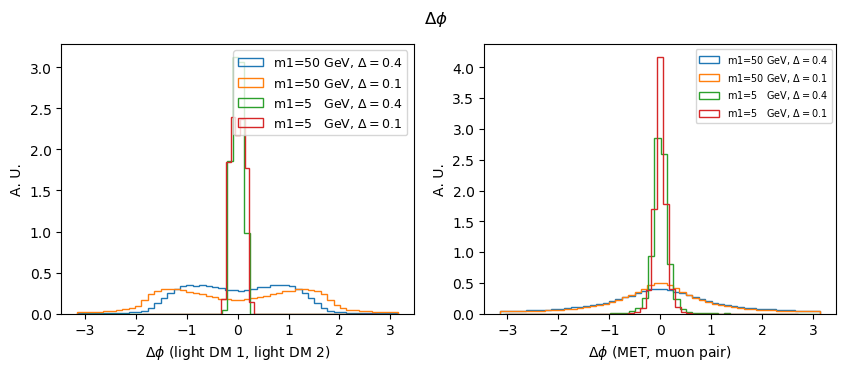

In [26]:
#phi1 = recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genPhi']
#phi2 = recoNewDfs[mchi][10].query('subentry==1').reset_index('subentry')['genPhi']
#avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
#reducedDf = pd.concat([avgPhi, recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genLeadMetPhi']], axis=1)
#phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']

fig, ax = plt.subplots(1,2, figsize=(10,3.5))
for mchi in mchis:
#    phidiff = genNewDfs[mchi][10].query('subentry==3').reset_index('subentry')['phi'] - \
#                genNewDfs[mchi][10].query('subentry==4').reset_index('subentry')['phi']
    crit2Mus = dsaGenMu[mchi][ctau].query('subentry==1').reset_index()['entry']
    eventsWith2Mus = dsaGenMu[mchi][ctau].reset_index().loc[dsaGenMu[mchi][ctau].reset_index()['entry'].isin(crit2Mus) ]
    phi1 = eventsWith2Mus.query('subentry==0')['gen_mu_phi'].reset_index()['gen_mu_phi']
    phi2 = eventsWith2Mus.query('subentry==1')['gen_mu_phi'].reset_index()['gen_mu_phi']
    avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
    
    phichi1_1 = eventsWith2Mus.query('subentry==0')['gen_chi1_phi'].reset_index()['gen_chi1_phi']
    phichi1_2 = eventsWith2Mus.query('subentry==1')['gen_chi1_phi'].reset_index()['gen_chi1_phi']
    
    phidiff = phichi1_1-phichi1_2
    reducedphidiff = phidiff.apply(reducephi)
    ax[0].hist(reducedphidiff, bins=50, density=True, histtype='step', label=labels[mchi])
    reducedDf = pd.concat([avgPhi, dsaGenAll[mchi][ctau]['gen_MET_phi']], axis=1)
#    reducedDf = pd.concat([avgPhi, dsaGenAll[mchi][ctau].query('subentry==0').reset_index('subentry')['gen_MET_phi']], axis=1)

    phidiff2 = reducedDf['gen_mu_phi'] - reducedDf['gen_MET_phi']
    reducedphidiff2 = phidiff2.apply(reducephi)
    ax[1].hist(reducedphidiff2,bins=50, density=True, histtype='step', label=labels[mchi], log=False);

ax[0].set_xlabel('$\Delta\phi$ (light DM 1, light DM 2)')
ax[0].set_ylabel('A. U.')
ax[0].legend(prop={'size': 9});
#mchi='60p0'
#reducedDf = pd.concat([avgPhi, dsaGenAll[mchi][ctau].query('subentry==0').reset_index('subentry')['gen_MET_phi']], axis=1)
#phidiff = reducedDf['gen_mu_phi'] - reducedDf['gen_MET_phi']
#reducedphidiff = phidiff.apply(reducephi)
#reducedDf
#fig, ax = plt.subplots(1,2, figsize=(10,3.5))
#ax[1].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);
ax[1].set_xlabel('$\Delta\phi$ (MET, muon pair)')
ax[1].set_ylabel('A. U.')
ax[1].legend(prop={'size': 7});
plt.suptitle('$\Delta\phi$')
plt.savefig("plots/GenKinematics/Gen_Chi1_MetMu_dPhi", bbox_inches='tight')

In [ ]:
# plt.figure(figsize=(5,3.5))
#fig, ax = plt.subplots(1,2, figsize=(10,3.5))
#
#for mchi in mchis:
#    phidiff = genNewDfs[mchi][10].query('subentry==3').reset_index('subentry')['phi'] - \
#                genNewDfs[mchi][10].query('subentry==4').reset_index('subentry')['phi']
#    reducedphidiff = phidiff.apply(reducephi)
#   ax[0].hist(reducedphidiff, bins=50, density=True, histtype='step', label=labels[mchi])

#ax[0].set_xlabel('$\Delta\phi$ (light DM 1, light DM 2)')
#ax[0].set_ylabel('A. U.')
#ax[0].legend(prop={'size': 9});
#
#for mchi in mchis:
#    phi1 = recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genPhi']
 #   phi2 = recoNewDfs[mchi][10].query('subentry==1').reset_index('subentry')['genPhi']
 #   avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
#    reducedDf = pd.concat([avgPhi, recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genLeadMetPhi']], axis=1)
#    phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
#    reducedphidiff = phidiff.apply(reducephi)
#    ax[1].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);
#
#ax[1].set_xlabel('$\Delta\phi$ (MET, muon pair)')
#ax[1].set_ylabel('A. U.')
#ax[1].legend(prop={'size': 9});
#
# phidiff = pd.concat([abs(2*math.pi - abs(genNewDfs['60'][10].query('subentry==3').reset_index('subentry')['phi']) - abs(genNewDfs['60'][10].query('subentry==4').reset_index('subentry')['phi'])), \
#         abs(genNewDfs['60'][10].query('subentry==3').reset_index('subentry')['phi'] - genNewDfs['60'][10].query('subentry==4').reset_index('subentry')['phi'])], axis=1).min(axis=1)

## Di-muon invariant mass plot

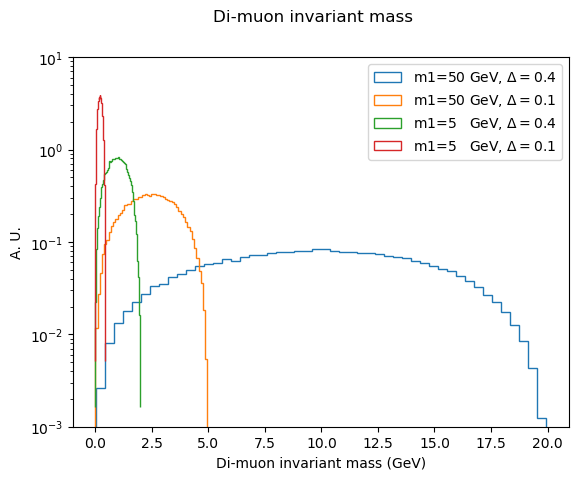

In [27]:
# M_A'^2 = (e1 + e2)^2 - (px1+px2)^2 + (py1+py2)^2 + (pz1+pz2)^2
# Or M_A'^2 = 2 * pT1 * pT2 * (cosh(eta1 - eta2) - cos(phi1 - phi2))
ctau='10'
for mchi in mchis:
    #reducedDf = genNewDfs[mchi][10].query('subentry==5|subentry==6')[['pt','eta','phi']]
    #idx = pd.IndexSlice
    #invMass = np.sqrt(2 * reducedDf.loc[idx[:,5], 'pt'].reset_index(level=1).drop(columns='subentry')['pt'] * \
    #reducedDf.loc[idx[:,6], 'pt'].reset_index(level=1).drop(columns='subentry')['pt'] * \
    #(np.cosh(reducedDf.loc[idx[:,5], 'eta'].reset_index(level=1).drop(columns='subentry')['eta'] - \
    #        reducedDf.loc[idx[:,6], 'eta'].reset_index(level=1).drop(columns='subentry')['eta']) - \
    #np.cos(reducedDf.loc[idx[:,5], 'phi'].reset_index(level=1).drop(columns='subentry')['phi'] - \
    #        reducedDf.loc[idx[:,6], 'phi'].reset_index(level=1).drop(columns='subentry')['phi'])))
    crit2Mus = dsaGenMu[mchi][ctau].query('subentry==1').reset_index()['entry']
    eventsWith2Mus = dsaGenMu[mchi][ctau].reset_index().loc[dsaGenMu[mchi][ctau].reset_index()['entry'].isin(crit2Mus) ]
    phi1 = eventsWith2Mus.query('subentry==0')['gen_mu_phi'].reset_index()['gen_mu_phi']
    phi2 = eventsWith2Mus.query('subentry==1')['gen_mu_phi'].reset_index()['gen_mu_phi']
    Mu1 = eventsWith2Mus.query('subentry==0').reset_index()
    Mu2 = eventsWith2Mus.query('subentry==1').reset_index()
    invMass = np.sqrt(2*Mu1['gen_mu_pt']*Mu2['gen_mu_pt']*(np.cosh(Mu1['gen_mu_eta']-Mu2['gen_mu_eta'])-np.cos(Mu1['gen_mu_phi']-Mu2['gen_mu_phi'])))
    plt.hist(invMass, bins=50, density=True, histtype='step', log=True, label=labels[mchi]);

plt.ylim([0.001, 10])
plt.suptitle('Di-muon invariant mass')
plt.xlabel('Di-muon invariant mass (GeV)')
plt.ylabel('A. U.')
plt.legend(loc='upper right');
plt.savefig("plots/GenKinematics/Gen_DiMu_invariant_mass", bbox_inches='tight')

## Test stuff